In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [2]:
import torch
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import *

In [3]:
res = 64
x = np.linspace(-1, 1, res)*2*np.pi
y = np.linspace(-1, 1, res)*2*np.pi
xx, yy = np.meshgrid(x,y)
mesh = np.stack([xx.ravel(), yy.ravel()], axis = -1)
space_maps = mesh.T.reshape(-1,res,res)

In [4]:
def ratemaps_fn(f, mesh, device):
    activity = f(torch.tensor(mesh.astype("float32"), device = device)).detach().cpu().numpy()
    activity = activity.T.reshape(-1,res,res)
    return activity

In [10]:
model = RNNGC()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.load('saved-models/RNNGC_1000.pkl')
model.to(device)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Show scaled and sorted (on scaled, mean, absolute activity) ratemaps

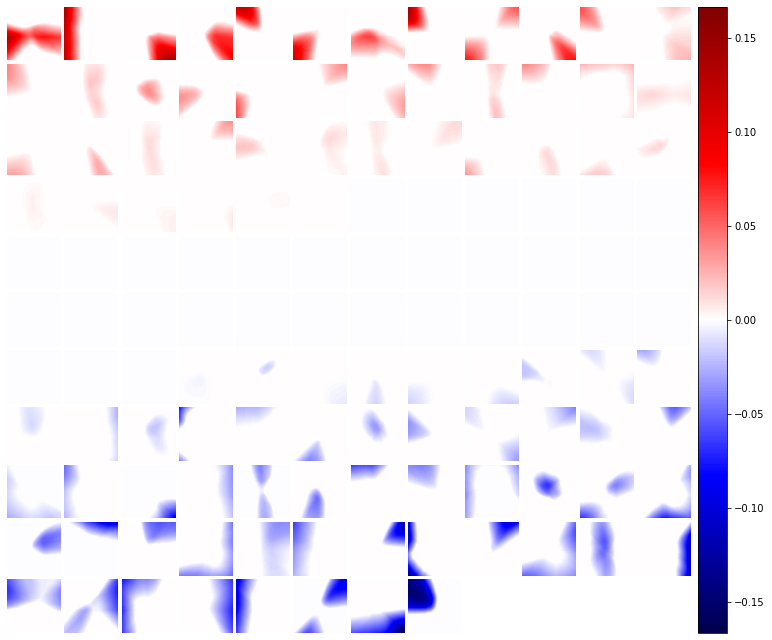

In [ ]:
# set the output unit ID and which layer to visualize
output_unit = 2
layer = 2 # ----> CHANGE THIS TO VISUALIZE DIFFERENT LAYERS <----

layer *= 2
weight = model.rg[layer].weight.detach().cpu().numpy()[output_unit][:,None,None]
weighted_ratemaps = ratemaps_fn(model.rg[:layer], mesh, device=device)*weight
sort_idxs = np.argsort(np.sum(weighted_ratemaps,axis=(1,2)))[::-1]
multiimshow(weighted_ratemaps[sort_idxs], figsize=(10,10), cmap='seismic', vrange='symmetric');

# Show ratemap(s) - including (norm) relu

0.23630625


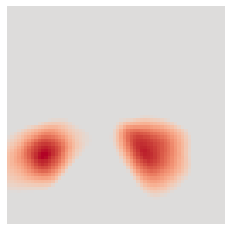

In [7]:
# choose layer ( rg[:2], rg[:4], lambda r: model.norm_relu(model.rg[:6](r)) )
output_unit = 2
f = lambda r: model.norm_relu(model.rg[:6](r)) # ----> CHANGE THIS TO VISUALIZE DIFFERENT LAYERS <----

fig, ax = plt.subplots(figsize=(4,4))
ratemaps = ratemaps_fn(f, mesh, device)
# set output color range
vmin = np.min(ratemaps[output_unit])
vmax = np.max(ratemaps[output_unit])
vrange = max(abs(vmin), abs(vmax))
im = ax.imshow(ratemaps[output_unit], cmap='coolwarm', vmin=-vrange, vmax=vrange)
ax.axis('off')
#fig.colorbar(im)
print(vrange)

# Show cumulative sum of scaled previous layer activations

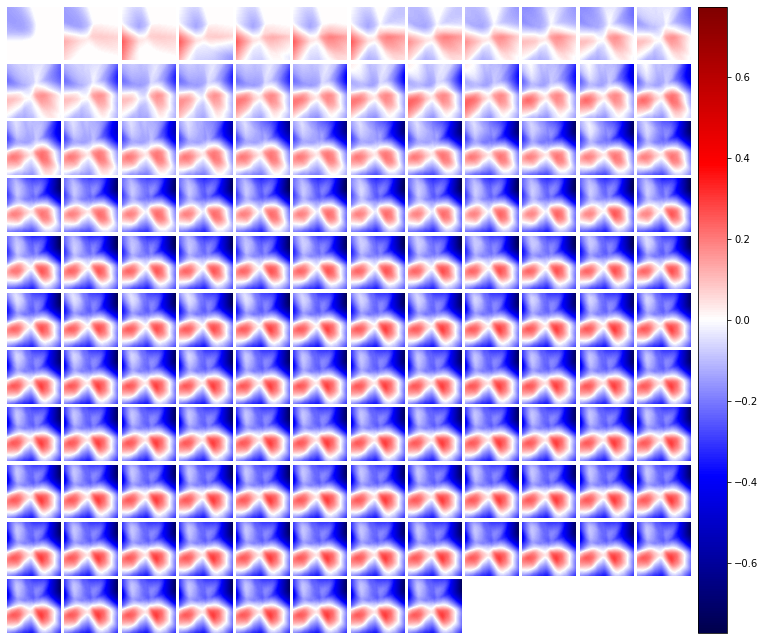

In [8]:
# set the output unit ID and which layer to visualize
output_unit = 2
layer = 2 # ----> CHANGE THIS TO VISUALIZE DIFFERENT LAYERS <----

layer *= 2
weight = model.rg[layer].weight.detach().cpu().numpy()[output_unit][:,None,None]
weighted_ratemaps = ratemaps_fn(model.rg[:layer], mesh, device=device)*weight
sort_idxs = np.argsort(abs(np.sum(weighted_ratemaps,axis=(1,2))))[::-1]
cumulative_weighted_ratemaps = np.cumsum(weighted_ratemaps[sort_idxs], axis=0)
multiimshow(cumulative_weighted_ratemaps, figsize=(10,10), cmap='seismic', vrange='symmetric');

# Visualise hidden representations

In [9]:
dataset = DatasetMaker()
r, v = dataset.generate_data(samples=100000, timesteps=10, device=device)

def rnn_ratemaps_fn(f, r, v, timestep=None, bins=64):
    activity = f((r[:,0], v)).detach().cpu().numpy()
    if timestep is not None:
        activity = activity[:,timestep]
        r = r[:,timestep]
    else:
        activity = activity.reshape(-1, activity.shape[-1]) # (bs*timesteps, units)
        r = r.reshape(-1, r.shape[-1])
    return scipy.stats.binned_statistic_2d(*r.detach().cpu().numpy().T, activity.T, bins=bins, statistic='mean').statistic

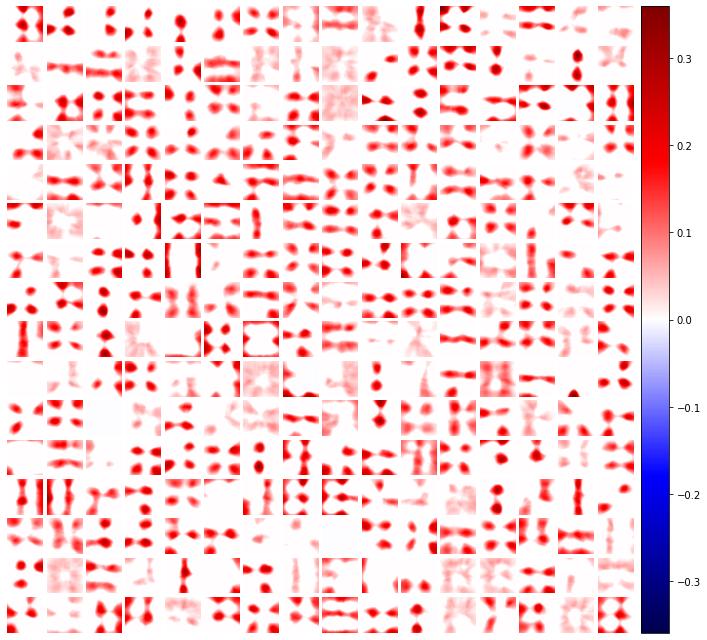

In [10]:
ratemaps = rnn_ratemaps_fn(model, r, v, timestep=0)
multiimshow(ratemaps, figsize=(10,10), cmap='seismic', vrange='symmetric');

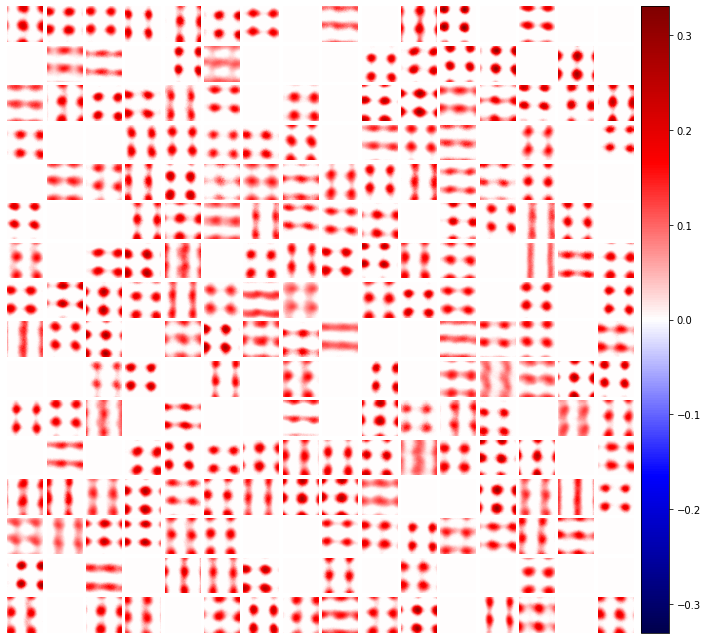

In [11]:
ratemaps = rnn_ratemaps_fn(model, r, v, timestep=9)
multiimshow(ratemaps, figsize=(10,10), cmap='seismic', vrange='symmetric');

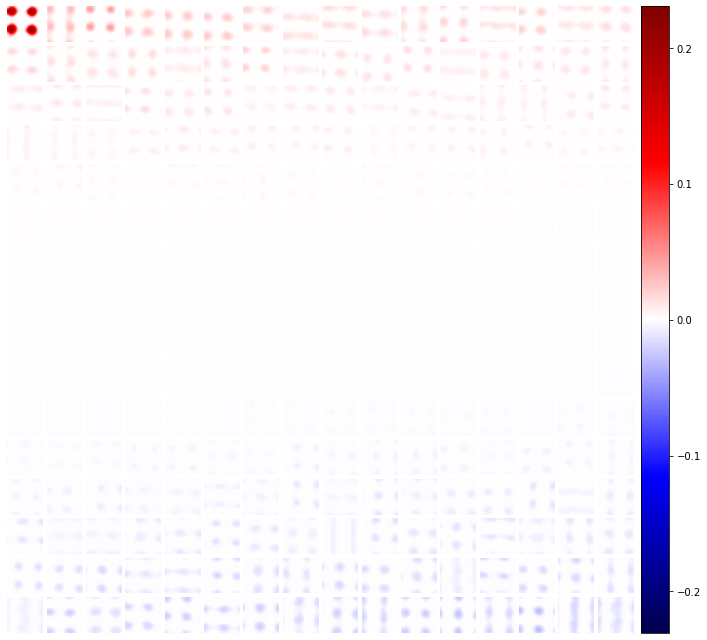

In [12]:
# set the output unit ID and which layer to visualize
output_unit = 2

weight = model.gg.weight.detach().cpu().numpy()[output_unit][:,None,None]
weighted_ratemaps = ratemaps*weight
sort_idxs = np.argsort(np.sum(weighted_ratemaps,axis=(1,2)))[::-1]
multiimshow(weighted_ratemaps[sort_idxs], figsize=(10,10), cmap='seismic', vrange='symmetric');

In [13]:
kernel = np.dot(np.transpose(ratemaps, (1,2,0)), ratemaps[:,::8,::8].transpose(1,0,2)).reshape(res,res,-1).transpose(2,0,1)
#kernel = np.sum((ratemaps[..., None, None] - ratemaps[:,::8,::8][:, None, None])**2,axis=0).reshape(res,res,-1).transpose(2,0,1)
kernel.shape

(64, 64, 64)

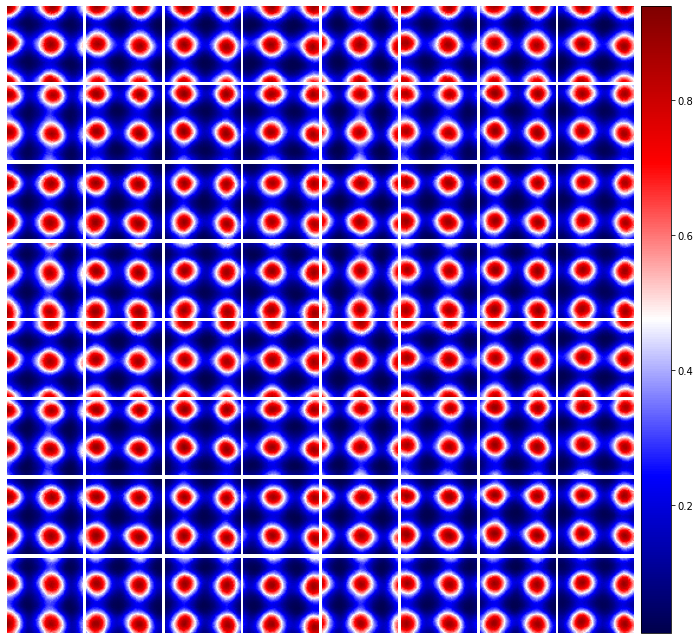

In [14]:
multiimshow(kernel, figsize=(10,10), cmap='seismic');#, vrange='symmetric');

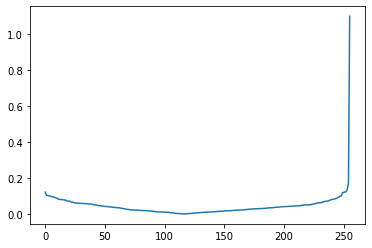

In [15]:
fig,ax=plt.subplots()
plt.plot(abs(np.sort(weight.flatten())))

In [16]:
ratemaps[:,::8,::8].reshape(ratemaps.shape[0],-1).T.shape

(64, 256)

In [19]:
import umap
projection = umap.UMAP(n_neighbors=32,n_components=3)
manifold = projection.fit_transform(ratemaps[:,::2,::2].reshape(ratemaps.shape[0],-1).T)
#manifold = projection.fit_transform(ratemaps.reshape(ratemaps.shape[0],-1).T)

KeyboardInterrupt: 

(2.1311779618263245, 7.187741458415985, -0.4422403752803803, 8.15562750697136)

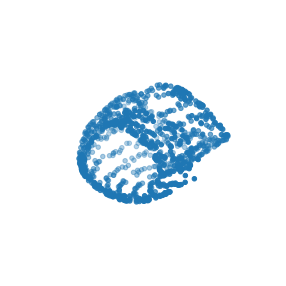

In [ ]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(5,5))#, dpi=300)
ax.scatter(*manifold.T)
ax.axis('off')